In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [2]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [3]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [4]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv', header=False, index=False)

train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv",30)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv",30)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv",30)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 30: 0
torch.Size([337179, 30]) torch.Size([337179])
length > 30: 0
torch.Size([84295, 30]) torch.Size([84295])
length > 30: 0
torch.Size([88998, 30]) torch.Size([88998])


# 2. train

In [7]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    


In [8]:
device = torch.device("cuda",0)

In [9]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 141.72971, loss1: 1.26427, loss2_3: 140.46543
	train_acc: 0.8006, test_acc: 0.8020404531704134, time: 182.94
best_acc: 0.8020404531704134
epoch: 2, loss: 106.03521, loss1: 0.85918, loss2_3: 105.17603
	train_acc: 0.8136, test_acc: 0.8124443917195563, time: 166.90
best_acc: 0.8124443917195563
epoch: 3, loss: 100.91383, loss1: 0.82091, loss2_3: 100.09292
	train_acc: 0.8255, test_acc: 0.8229313719674951, time: 147.29
best_acc: 0.8229313719674951
epoch: 4, loss: 97.16583, loss1: 0.78581, loss2_3: 96.38002
	train_acc: 0.8373, test_acc: 0.8347470193961682, time: 146.37
best_acc: 0.8347470193961682
epoch: 5, loss: 95.24379, loss1: 0.76622, loss2_3: 94.47757
	train_acc: 0.8424, test_acc: 0.8400616881191055, time: 146.90
best_acc: 0.8400616881191055
epoch: 6, loss: 94.07538, loss1: 0.75839, loss2_3: 93.31699
	train_acc: 0.8387, test_acc: 0.8358265614805148, time: 156.36
epoch: 7, loss: 92.99706, loss1: 0.74702, loss2_3: 92.25005
	train_acc: 0.8429, test_acc: 0.8405243490123969, t

epoch: 58, loss: 83.01435, loss1: 0.65806, loss2_3: 82.35629
	train_acc: 0.8598, test_acc: 0.8551752772999585, time: 182.64
epoch: 59, loss: 82.96769, loss1: 0.65893, loss2_3: 82.30876
	train_acc: 0.8617, test_acc: 0.8567174802775965, time: 184.47
epoch: 60, loss: 82.94025, loss1: 0.65653, loss2_3: 82.28371
	train_acc: 0.8550, test_acc: 0.850762204163948, time: 183.61
epoch: 61, loss: 82.91787, loss1: 0.65620, loss2_3: 82.26167
	train_acc: 0.8606, test_acc: 0.8562073669849932, time: 182.57
epoch: 62, loss: 82.81753, loss1: 0.65992, loss2_3: 82.15761
	train_acc: 0.8615, test_acc: 0.8572869090693398, time: 183.27
best_acc: 0.8572869090693398
epoch: 63, loss: 82.83877, loss1: 0.65574, loss2_3: 82.18303
	train_acc: 0.8615, test_acc: 0.8561243252861973, time: 183.93
epoch: 64, loss: 82.89647, loss1: 0.65693, loss2_3: 82.23954
	train_acc: 0.8597, test_acc: 0.8553650868972063, time: 183.61
epoch: 65, loss: 82.76395, loss1: 0.65781, loss2_3: 82.10614
	train_acc: 0.8605, test_acc: 0.85580402159

epoch: 118, loss: 81.17464, loss1: 0.64407, loss2_3: 80.53058
	train_acc: 0.8646, test_acc: 0.8573818138679637, time: 115.50
epoch: 119, loss: 81.17422, loss1: 0.64581, loss2_3: 80.52841
	train_acc: 0.8589, test_acc: 0.8525060798386619, time: 115.69
epoch: 120, loss: 81.22434, loss1: 0.64533, loss2_3: 80.57901
	train_acc: 0.8657, test_acc: 0.8588884275461178, time: 115.92
epoch: 121, loss: 81.11629, loss1: 0.64232, loss2_3: 80.47397
	train_acc: 0.8634, test_acc: 0.8574174031674476, time: 115.24
epoch: 122, loss: 81.10393, loss1: 0.64410, loss2_3: 80.45983
	train_acc: 0.8652, test_acc: 0.8578088854617711, time: 116.18
epoch: 123, loss: 81.05865, loss1: 0.64247, loss2_3: 80.41619
	train_acc: 0.8649, test_acc: 0.8580817367578149, time: 114.68
epoch: 124, loss: 81.03256, loss1: 0.64517, loss2_3: 80.38739
	train_acc: 0.8623, test_acc: 0.8563734503825849, time: 115.68
epoch: 125, loss: 81.01588, loss1: 0.64400, loss2_3: 80.37189
	train_acc: 0.8656, test_acc: 0.8581529153567827, time: 114.84


epoch: 179, loss: 80.17669, loss1: 0.63985, loss2_3: 79.53684
	train_acc: 0.8658, test_acc: 0.857097099472092, time: 115.87
epoch: 180, loss: 80.12540, loss1: 0.63856, loss2_3: 79.48684
	train_acc: 0.8643, test_acc: 0.8559226525891216, time: 116.19
epoch: 181, loss: 80.15438, loss1: 0.63826, loss2_3: 79.51612
	train_acc: 0.8674, test_acc: 0.8585088083516222, time: 115.39
epoch: 182, loss: 80.07898, loss1: 0.63603, loss2_3: 79.44295
	train_acc: 0.8677, test_acc: 0.8584613559523103, time: 114.94
epoch: 183, loss: 80.07644, loss1: 0.64061, loss2_3: 79.43583
	train_acc: 0.8659, test_acc: 0.8577258437629752, time: 114.72
epoch: 184, loss: 80.12499, loss1: 0.63823, loss2_3: 79.48676
	train_acc: 0.8682, test_acc: 0.8597662969333887, time: 116.89
epoch: 185, loss: 80.11017, loss1: 0.63621, loss2_3: 79.47396
	train_acc: 0.8671, test_acc: 0.8584613559523103, time: 115.12
epoch: 186, loss: 80.08404, loss1: 0.63919, loss2_3: 79.44485
	train_acc: 0.8651, test_acc: 0.8572513197698559, time: 115.88
e

epoch: 241, loss: 79.19835, loss1: 0.63267, loss2_3: 78.56568
	train_acc: 0.8680, test_acc: 0.8578682009609111, time: 82.78
epoch: 242, loss: 79.26755, loss1: 0.63614, loss2_3: 78.63142
	train_acc: 0.8696, test_acc: 0.8594104039385492, time: 82.82
epoch: 243, loss: 79.37116, loss1: 0.63459, loss2_3: 78.73657
	train_acc: 0.8696, test_acc: 0.8581054629574708, time: 82.79
epoch: 244, loss: 79.14375, loss1: 0.63611, loss2_3: 78.50765
	train_acc: 0.8703, test_acc: 0.8591612788421614, time: 82.87
epoch: 245, loss: 79.14292, loss1: 0.63443, loss2_3: 78.50849
	train_acc: 0.8701, test_acc: 0.8582240939557506, time: 82.84
epoch: 246, loss: 79.15617, loss1: 0.63455, loss2_3: 78.52162
	train_acc: 0.8688, test_acc: 0.8582596832552346, time: 82.88
epoch: 247, loss: 79.25144, loss1: 0.63312, loss2_3: 78.61832
	train_acc: 0.8704, test_acc: 0.8598374755323566, time: 82.82
epoch: 248, loss: 79.07768, loss1: 0.63400, loss2_3: 78.44368
	train_acc: 0.8702, test_acc: 0.8601459161278843, time: 82.69
epoch: 2

# 3. test

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [11]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [12]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [13]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.8695813389064923
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     44509
           1       0.84      0.92      0.88     44489

    accuracy                           0.87     88998
   macro avg       0.87      0.87      0.87     88998
weighted avg       0.87      0.87      0.87     88998



rf auc : 0.9434979526444047


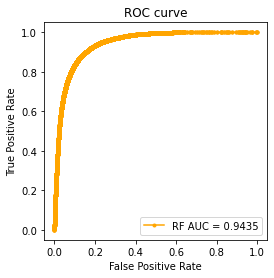

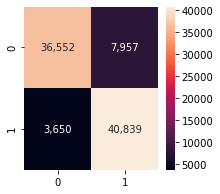

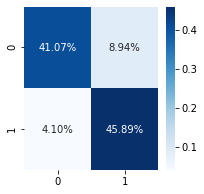

In [14]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]
rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()